In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
import random

random.seed(42)
random.shuffle(words)

In [20]:
# build the dataset
block_size = (
    8 # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [21]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [53]:
# Let's train a deep neural network


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:
    
    def __init__(self, num_embedding, embedding_dim):
        self.weight = torch.randn((num_embedding, embedding_dim))
    
    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        self.out = x
        return self.out
    
    def parameters(self):
        # get the parameters of all layers and stretch them out into on single layer
        return [p for layer in self.layers for p in layer.parameters()]

In [10]:
torch.manual_seed(42) # seed rng for reproducibility

In [61]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 128  # the  number of neurons in the hidden layer of the MLP

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of paramterts in total
for p in parameters:
    p.requires_grad = True

72617


In [44]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
Xb.shape, Xb

(torch.Size([4, 8]),
 tensor([[ 0,  0,  0,  0,  0, 13, 15, 13],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [15, 18,  1, 12,  5,  9,  7,  8],
         [ 0,  0,  0,  0,  0,  0,  0,  0]]))

In [56]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1D : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1D : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1D : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [57]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [ ]:
model.layers[0].out.shape  # output of embedding layer

torch.Size([4, 8, 10])

In [29]:
model.layers[1].out.shape  # output of flatten layer

torch.Size([4, 80])

In [30]:
model.layers[2].out.shape  # output of linear layer

torch.Size([4, 200])

In [32]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [33]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [35]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [36]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [62]:
# same optimization as the last time

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward  pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if i%10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.2785
  10000/ 200000: 1.8924
  20000/ 200000: 2.1568
  30000/ 200000: 1.5086
  40000/ 200000: 2.1942
  50000/ 200000: 2.0039
  60000/ 200000: 1.9365
  70000/ 200000: 1.8837
  80000/ 200000: 2.1480
  90000/ 200000: 1.6949
 100000/ 200000: 2.2709
 110000/ 200000: 1.3570
 120000/ 200000: 2.1665
 130000/ 200000: 1.8022
 140000/ 200000: 1.7110
 150000/ 200000: 1.9329
 160000/ 200000: 1.8154
 170000/ 200000: 1.9129
 180000/ 200000: 1.7777
 190000/ 200000: 2.3665


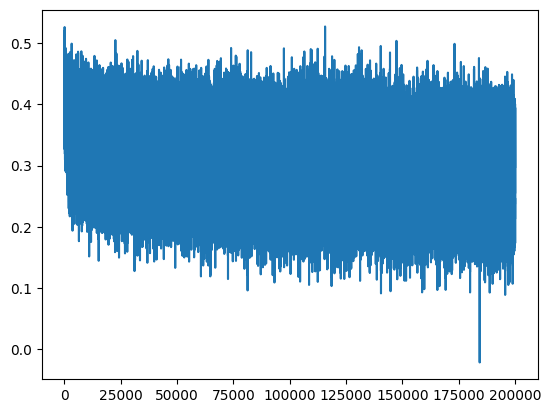

In [48]:
plt.plot(lossi)

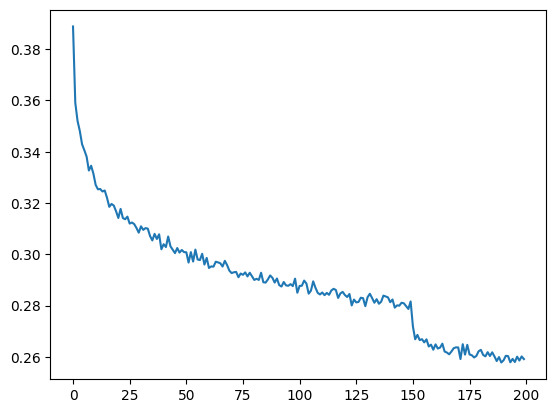

In [63]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [64]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


# put layers into eval mode
for layer in model.layers:
    layer.training = False
split_loss("train")
split_loss("val")

train 1.7989234924316406
val 1.990604281425476


**Block Size: 3** train 2.0583250522613525
                  val   2.1065292358398438

**Block Size: 8** train 1.9183448553085327
val 2.026494264602661

**Changing into wavenet 68 hidden neurons** train 1.940284013748169
val: 2.0260565280914307

**Fixed the bug in BatchNorm layer** train 1.9122380018234253
val 2.0179848670959473

**128 hidden neurons** train 1.7989234924316406
val 1.990604281425476

In [65]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:

        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

india.
makenly.
marksher.
rosabeth.
charleigh.
coron.
kimari.
wilfrazia.
maburnate.
aldon.
elizetty.
leelyn.
heeyansh.
jacquelynn.
ashtin.
tighana.
heavina.
meralda.
angelouc.
ibhima.


## Convolutional layer

In [66]:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [67]:
# forward a single example
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [68]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])

logits.shape

torch.Size([8, 27])

In [69]:
# convolution is a for loop
# allowing us to forward linear layers efficiently over space